In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import os

In [19]:
# 1.1 Define CONUS (contiguous United States) bounds
CONUS_BOUNDS = {
    "lat": (25.0, 50.1),
    "lng": (-130.0, -64.9)
}
step = 0.25

In [20]:
# 1.2 Generate a grid of 0.25 deg x 0.25 deg rectangular polygons and save it as a GeoJSON file

lat_range = np.arange(CONUS_BOUNDS["lat"][0], CONUS_BOUNDS["lat"][1], step)
lng_range = np.arange(CONUS_BOUNDS["lng"][0], CONUS_BOUNDS["lng"][1], step)

grid_cells = []
for lat in lat_range:
    for lng in lng_range:
        grid_cells.append(Polygon([
            (lng, lat),
            (lng + step, lat),
            (lng + step, lat + step),
            (lng, lat + step),
        ]))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:4326")
grid['grid_id'] = grid.index.astype(str)
# 1.3 Filter to U.S. land cells using cencus TIGER shapefile
# Keep only grid cells that are in the lower 48 states 
us_shape = gpd.read_file("./data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp").to_crs("EPSG:4326")
us_shape = us_shape[~us_shape['STUSPS'].isin(['AK', 'HI', 'PR'])] 
grid = gpd.overlay(grid, us_shape[['geometry']], how='intersection')
grid.to_file("./data/grid.geojson", driver='GeoJSON')
grid


,grid_id,geometry
0,195,"POLYGON ((-81 25.25, -81 25.12432, -81.0096 25..."
1,196,"POLYGON ((-81 25.25, -80.75 25.25, -80.75 25.1..."
2,197,"MULTIPOLYGON (((-80.55905 25, -80.54476 25.012..."
3,198,"POLYGON ((-80.5 25.25, -80.3103 25.25, -80.327..."
4,456,"POLYGON ((-81 25.5, -81 25.25, -81.16944 25.25..."
...,...,...
15433,25195,"POLYGON ((-95 49.25, -95 49, -95.15371 49, -95..."
15434,25196,"POLYGON ((-94.75 49, -95 49, -95 49.25, -94.80..."
15435,25197,"POLYGON ((-94.75 49, -94.75 49.09906, -94.7189..."
15436,25456,"POLYGON ((-95 49.25, -95.15342 49.25, -95.1533..."


In [21]:
grid['grid_id'].duplicated().sum()  # Check for duplicates

1717

In [22]:
# 2.1 Read corrected_disaster_data.xlsx into a GPD DataFrame
disaster_data_path = '/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Data/Natural Disasters/corrected_disaster_data.xlsx'
disaster_df = pd.read_excel(disaster_data_path, engine='openpyxl').dropna(subset=['latitude', 'longitude']).drop(columns=["Latitude", "Longitude"])
disaster_df

,id,country_x,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,...,Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),CPI,Admin Units,Entry Date,Last Update,Disaster Type,Country,Location
0,109,Albania,ALB,339.0,2009,346,Ana E Malit,3,Shkoder,Shkodres,...,NaN,NaN,NaN,73.307177,"[{""adm2_code"":3963,""adm2_name"":""Shengjin""},{""a...",2014-07-28,2023-09-25,NaN,NaN,NaN
1,109,Albania,ALB,339.0,2009,351,Bushat,3,Shkoder,Shkodres,...,NaN,NaN,NaN,73.307177,"[{""adm2_code"":3963,""adm2_name"":""Shengjin""},{""a...",2014-07-28,2023-09-25,NaN,NaN,NaN
2,175,Angola,AGO,540.0,2001,760,Onjiva,3,Cunene,Cuanhama,...,NaN,NaN,NaN,60.503579,"[{""adm1_code"":398,""adm1_name"":""Bengo""},{""adm2_...",2005-09-19,2023-09-25,NaN,NaN,NaN
3,187,Angola,AGO,540.0,2009,710,Evale,3,Cunene,Cuanhama,...,NaN,NaN,NaN,73.307177,"[{""adm1_code"":400,""adm1_name"":""Bie""},{""adm1_co...",2010-08-16,2023-09-25,NaN,NaN,NaN
4,187,Angola,AGO,540.0,2009,749,Mupa,3,Cunene,Cuvelai,...,NaN,NaN,NaN,73.307177,"[{""adm1_code"":400,""adm1_name"":""Bie""},{""adm1_co...",2010-08-16,2023-09-25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39948,1994-06-01 00:00:00,Dominica,NaN,NaN,2015,45253,Saint Patrick,1,Saint Patrick,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39949,1994-06-01 00:00:00,Dominica,NaN,NaN,2015,45254,Saint Andrew,1,Saint Andrew,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39950,1994-06-01 00:00:00,Dominica,NaN,NaN,2015,45255,Saint George,1,Saint George,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39951,1994-06-01 00:00:00,Dominica,NaN,NaN,2015,45256,Saint David,1,Saint David,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# 2.2 Filter the disaster data to only include disasters in the U.S. and within the CONUS bounds
disaster_df = disaster_df[disaster_df['iso3'] == 'USA']
disaster_df = disaster_df[disaster_df['latitude'].between(CONUS_BOUNDS['lat'][0], CONUS_BOUNDS['lat'][1]) &
                          disaster_df['longitude'].between(CONUS_BOUNDS['lng'][0], CONUS_BOUNDS['lng'][1])]
assert disaster_df[disaster_df['country_x'] == 'United States'].shape[0] == disaster_df.shape[0], "Country mismatch in disaster data"
assert disaster_df['iso3'].nunique() == 1, "Multiple ISO3 codes found in disaster data"
assert disaster_df['latitude'].between(CONUS_BOUNDS['lat'][0], CONUS_BOUNDS['lat'][1]).all(), "Latitude out of bounds"
assert disaster_df['longitude'].between(CONUS_BOUNDS['lng'][0], CONUS_BOUNDS['lng'][1]).all(), "Longitude out of bounds"
disaster_df

,id,country_x,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,...,Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),CPI,Admin Units,Entry Date,Last Update,Disaster Type,Country,Location
5482,6582,United States,USA,2.0,1983,23213,Bonneville,2,Idaho,Bonneville,...,NaN,NaN,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)"
5483,6582,United States,USA,2.0,1983,23473,Custer,2,Idaho,Custer,...,NaN,NaN,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)"
5484,6592,United States,USA,2.0,1985,24776,Morgan,2,Illinois,Morgan,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Rome, Peoria, Liverpool, Chillicothe, Meredosi..."
5485,6593,United States,USA,2.0,1985,24351,Macomb,2,Michigan,Macomb,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol..."
5486,6593,United States,USA,2.0,1985,24750,Monroe,2,Michigan,Monroe,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,07-285,United States,USA,2.0,2018,45123,Minnesota,1,Minnesota,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39836,07-285,United States,USA,2.0,2018,45124,Louisiana,1,Louisiana,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39837,07-285,United States,USA,2.0,2018,45125,New Mexico,1,New Mexico,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39838,07-285,United States,USA,2.0,2018,45126,Iowa,1,Iowa,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN


In [24]:
disaster_df[['disastertype_x', 'disastertype_y', 'Disaster Type', 'Disaster Subtype']].isna().sum()

disastertype_x         0
disastertype_y      1345
Disaster Type       2472
Disaster Subtype      21
dtype: int64

In [25]:
disaster_df['disastertype_x'].value_counts()

disastertype_x
storm                   2841
flood                    675
extreme temperature      154
drought                   74
earthquake                44
landslide                  7
volcanic activity          1
Name: count, dtype: int64

In [26]:
# 2.3 Filter the disaster data to only include disasters of interest
RADIUS_KM = {
    'flood': 25.0,
    'storm': 25.0,
    'storm': 25.0,
    'earthquake': 100.0,
    'volcanic activity': 100.0,
}
disaster_df = disaster_df[disaster_df['disastertype_x'].isin(set(RADIUS_KM.keys()))]
disaster_df

,id,country_x,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,...,Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),CPI,Admin Units,Entry Date,Last Update,Disaster Type,Country,Location
5482,6582,United States,USA,2.0,1983,23213,Bonneville,2,Idaho,Bonneville,...,NaN,NaN,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)"
5483,6582,United States,USA,2.0,1983,23473,Custer,2,Idaho,Custer,...,NaN,NaN,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)"
5484,6592,United States,USA,2.0,1985,24776,Morgan,2,Illinois,Morgan,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Rome, Peoria, Liverpool, Chillicothe, Meredosi..."
5485,6593,United States,USA,2.0,1985,24351,Macomb,2,Michigan,Macomb,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol..."
5486,6593,United States,USA,2.0,1985,24750,Monroe,2,Michigan,Monroe,...,NaN,NaN,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,07-285,United States,USA,2.0,2018,45123,Minnesota,1,Minnesota,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39836,07-285,United States,USA,2.0,2018,45124,Louisiana,1,Louisiana,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39837,07-285,United States,USA,2.0,2018,45125,New Mexico,1,New Mexico,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN
39838,07-285,United States,USA,2.0,2018,45126,Iowa,1,Iowa,NaN,...,NaN,NaN,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN


In [27]:
# 2.4 Map the disaster types to their corresponding radii
disaster_df = gpd.GeoDataFrame(
    disaster_df,
    geometry=gpd.points_from_xy(disaster_df['longitude'], disaster_df['latitude']),
    crs="EPSG:4326"
)
disaster_df['radius_km'] = disaster_df['disastertype_x'].map(RADIUS_KM)
disaster_df = disaster_df.to_crs("EPSG:3857")  
disaster_df['geometry'] = disaster_df.buffer(disaster_df['radius_km'] * 1000) 
disaster_df = disaster_df.to_crs("EPSG:4326")
disaster_df

,id,country_x,iso3,gwno,year,geo_id,geolocation,level,adm1,adm2,...,Total Damage ('000 US$),CPI,Admin Units,Entry Date,Last Update,Disaster Type,Country,Location,geometry,radius_km
5482,6582,United States,USA,2.0,1983,23213,Bonneville,2,Idaho,Bonneville,...,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)","POLYGON ((-110.71584 43.38826, -110.72017 43.3...",100.0
5483,6582,United States,USA,2.0,1983,23473,Custer,2,Idaho,Custer,...,15000.0,34.033264,NaN,2007-11-08,2023-09-25,Earthquake,United States of America,"Borah Peak, Challis, Mackay (Eastern Idaho)","POLYGON ((-104.46648 38.10828, -104.47081 38.0...",100.0
5484,6592,United States,USA,2.0,1985,24776,Morgan,2,Illinois,Morgan,...,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Rome, Peoria, Liverpool, Chillicothe, Meredosi...","POLYGON ((-86.6268 34.45362, -86.62788 34.4354...",25.0
5485,6593,United States,USA,2.0,1985,24351,Macomb,2,Michigan,Macomb,...,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol...","POLYGON ((-82.70761 42.69451, -82.70869 42.678...",25.0
5486,6593,United States,USA,2.0,1985,24750,Monroe,2,Michigan,Monroe,...,NaN,36.755468,NaN,2003-07-01,2023-09-25,Flood,United States of America,"Monroe, Macomb, Wayne counties (Michigan), Tol...","POLYGON ((-87.13996 31.57128, -87.14105 31.552...",25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39835,07-285,United States,USA,2.0,2018,45123,Minnesota,1,Minnesota,NaN,...,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN,"POLYGON ((-93.97118 46.35299, -93.97226 46.337...",25.0
39836,07-285,United States,USA,2.0,2018,45124,Louisiana,1,Louisiana,NaN,...,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN,"POLYGON ((-91.78712 31.07754, -91.78821 31.058...",25.0
39837,07-285,United States,USA,2.0,2018,45125,New Mexico,1,New Mexico,NaN,...,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN,"POLYGON ((-105.88328 34.42154, -105.88436 34.4...",25.0
39838,07-285,United States,USA,2.0,2018,45126,Iowa,1,Iowa,NaN,...,150000.0,85.803026,"[{""adm1_code"":3229,""adm1_name"":""Iowa""},{""adm1_...",2019-01-02,2023-09-25,NaN,NaN,NaN,"POLYGON ((-93.2756 42.07608, -93.27668 42.0597...",25.0


In [28]:
disaster_df = disaster_df[['id', 'disastertype_x', 'Start Year', 'geometry', 'radius_km', 'Total Deaths']]
disaster_df = disaster_df.rename(columns={
    'id': 'disaster_id',
    'disastertype_x': 'disastertype',
    'Start Year': 'year',
    'Total Deaths': 'total_deaths'
})
disaster_df

,disaster_id,disastertype,year,geometry,radius_km,total_deaths
5482,6582,earthquake,1983.0,"POLYGON ((-110.71584 43.38826, -110.72017 43.3...",100.0,2.0
5483,6582,earthquake,1983.0,"POLYGON ((-104.46648 38.10828, -104.47081 38.0...",100.0,2.0
5484,6592,flood,1985.0,"POLYGON ((-86.6268 34.45362, -86.62788 34.4354...",25.0,4.0
5485,6593,flood,1985.0,"POLYGON ((-82.70761 42.69451, -82.70869 42.678...",25.0,NaN
5486,6593,flood,1985.0,"POLYGON ((-87.13996 31.57128, -87.14105 31.552...",25.0,NaN
...,...,...,...,...,...,...
39835,07-285,storm,2018.0,"POLYGON ((-93.97118 46.35299, -93.97226 46.337...",25.0,2.0
39836,07-285,storm,2018.0,"POLYGON ((-91.78712 31.07754, -91.78821 31.058...",25.0,2.0
39837,07-285,storm,2018.0,"POLYGON ((-105.88328 34.42154, -105.88436 34.4...",25.0,2.0
39838,07-285,storm,2018.0,"POLYGON ((-93.2756 42.07608, -93.27668 42.0597...",25.0,2.0


In [29]:
# 3.1 Spatial join CONUS grid with disaster data
grid = gpd.read_file("./data/grid.geojson")
grid = grid.to_crs("EPSG:4326")
grid_hits = gpd.sjoin(grid, disaster_df, how="left", predicate='intersects')
grid_hits

,grid_id,geometry,index_right,disaster_id,disastertype,year,radius_km,total_deaths
0,195,"POLYGON ((-81 25.25, -81 25.12432, -81.0096 25...",NaN,NaN,NaN,NaN,NaN,NaN
1,196,"POLYGON ((-81 25.25, -80.75 25.25, -80.75 25.1...",NaN,NaN,NaN,NaN,NaN,NaN
2,197,"MULTIPOLYGON (((-80.55905 25, -80.54476 25.012...",NaN,NaN,NaN,NaN,NaN,NaN
3,198,"POLYGON ((-80.5 25.25, -80.3103 25.25, -80.327...",NaN,NaN,NaN,NaN,NaN,NaN
4,456,"POLYGON ((-81 25.5, -81 25.25, -81.16944 25.25...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
15433,25195,"POLYGON ((-95 49.25, -95 49, -95.15371 49, -95...",NaN,NaN,NaN,NaN,NaN,NaN
15434,25196,"POLYGON ((-94.75 49, -95 49, -95 49.25, -94.80...",NaN,NaN,NaN,NaN,NaN,NaN
15435,25197,"POLYGON ((-94.75 49, -94.75 49.09906, -94.7189...",NaN,NaN,NaN,NaN,NaN,NaN
15436,25456,"POLYGON ((-95 49.25, -95.15342 49.25, -95.1533...",NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# 3.2 Create a panel dataset, for each (grid_id, year) pair, set hit = 1 if any disaster_id intersects and count = number of intersecting disaster_ids
grid_disaster_panel = (
    grid_hits.dropna(subset=['disaster_id'])
    .groupby(['grid_id', 'year'])
    .agg(hit=('disaster_id', lambda x: 1),
            count=('disaster_id', 'nunique'),
            total_deaths=('total_deaths', 'sum'))
    .reset_index()
)
grid_disaster_panel.to_parquet("./data/grid_disaster_panel.parquet", index=False)
grid_disaster_panel

,grid_id,year,hit,count,total_deaths
0,10012,1987.0,1,1,61.0
1,10012,1988.0,1,1,0.0
2,10012,1989.0,1,1,0.0
3,10012,1992.0,1,2,0.0
4,10012,1995.0,1,1,18.0
...,...,...,...,...,...
13550,9974,2010.0,1,1,0.0
13551,9975,1992.0,1,1,1.0
13552,9975,1994.0,1,1,60.0
13553,9976,1992.0,1,1,1.0


In [31]:
# 4.1 Load the inventors dataset and filter for patents in the CONUS bounds
inventors_df = pd.read_csv("/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/Patent Data/US Patents Data.csv", usecols=['patent_id', 'inventor_id', 'patent_date', 'latitude', 'longitude'], dtype={
    'inventor_id': str,
    'patent_date': str,
    'latitude': float,
    'longitude': float
})
inventors_df = inventors_df[inventors_df['latitude'].between(CONUS_BOUNDS['lat'][0], CONUS_BOUNDS['lat'][1]) &
                            inventors_df['longitude'].between(CONUS_BOUNDS['lng'][0], CONUS_BOUNDS['lng'][1])]
inventors_df['patent_year'] = pd.to_datetime(inventors_df['patent_date']).dt.year
inventors_df = inventors_df.drop(columns=['patent_date'])

# 4.2 Create a GeoDataFrame for inventors
inventors_df = gpd.GeoDataFrame(
    inventors_df[['patent_id', 'inventor_id', 'patent_year']],
    geometry=gpd.points_from_xy(inventors_df['longitude'], inventors_df['latitude']),
    crs="EPSG:4326"
)
inventors_df

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_21412/3840244555.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  inventors_df = pd.read_csv("/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/Patent Data/US Patents Data.csv", usecols=['patent_id', 'inventor_id', 'patent_date', 'latitude', 'longitude'], dtype={


,patent_id,inventor_id,patent_year,geometry
0,10000000,fl:jo_ln:marron-5,2018,POINT (-118.39512 33.8916)
1,10000007,fl:co_ln:dickert-1,2018,POINT (-88.1262 43.05785)
2,10000007,fl:ja_ln:kotes-1,2018,POINT (-87.95342 43.31973)
3,10000007,fl:wi_ln:didier-2,2018,POINT (-87.98753 43.29665)
4,10000007,fl:ia_ln:zimmermann-1,2018,POINT (-88.00703 43.01668)
...,...,...,...,...
9325235,RE49666,fl:ch_ln:pedicini-3,2023,POINT (-86.86894 35.92521)
9325236,RE49667,fl:wi_ln:fox-10,2023,POINT (-98.93586 29.72356)
9325237,RE49673,fl:al_ln:wetter-1,2023,POINT (-122.33006 47.60383)
9325238,RE49673,fl:da_ln:steeves-2,2023,POINT (-122.33006 47.60383)


In [32]:
inventors_df['inventor_id'].nunique()

1620187

In [33]:
# 4.3 Spatial join inventors with the CONUS grid
inventors_grid = gpd.sjoin(inventors_df, grid[['grid_id', 'geometry']], how="left", predicate='within')
grid_inventors_panel = (
    inventors_grid.dropna(subset=['grid_id'])
    .groupby(['grid_id', 'patent_year'])
    .agg(n_inventors=('inventor_id', 'nunique'))
    .reset_index()
    .rename(columns={'patent_year': 'year'})
)
grid_inventors_panel.to_parquet("./data/grid_inventors_panel.parquet", index=False)
grid_inventors_panel


,grid_id,year,n_inventors
0,10010,1997,1
1,10010,1998,3
2,10010,1999,3
3,10010,2001,2
4,10010,2002,2
...,...,...,...
118303,9997,2014,1
118304,9997,2015,1
118305,9997,2016,1
118306,9997,2020,1


In [34]:
# 5.1 Create Cartesian index of all grid_id and study years
years = list(range(1995, 2019)) # 1995 to 2018 inclusive
cartesian_index = pd.MultiIndex.from_product(
    [grid['grid_id'], years],
    names=['grid_id', 'year']
).to_frame(index=False)
assert cartesian_index['grid_id'].nunique() == grid['grid_id'].nunique(), "Grid IDs do not match"
assert cartesian_index['year'].nunique() == len(years), "Years do not match"
assert cartesian_index.shape[0] == len(grid['grid_id']) * len(years), "Cartesian index size mismatch"
cartesian_index

,grid_id,year
0,195,1995
1,195,1996
2,195,1997
3,195,1998
4,195,1999
...,...,...
370507,25457,2014
370508,25457,2015
370509,25457,2016
370510,25457,2017


In [35]:
# 5.2 Use the Cartesian index to merge the grid x disaster panel and grid x inventors panel
# This creates a complete panel dataset, detailing the number of disasters and inventors for each grid cell in CONUS for each year
merged_grid_inventors_panel = (
    cartesian_index
    .merge(grid_disaster_panel, on=['grid_id', 'year'], how='left')
    .merge(grid_inventors_panel, on=['grid_id', 'year'], how='left')
)
merged_grid_inventors_panel.fillna({
    'hit': 0,
    'count': 0,
    'n_inventors': 0
}, inplace=True)
merged_grid_inventors_panel.to_parquet("./data/merged_grid_inventors_panel.parquet", index=False)
merged_grid_inventors_panel

,grid_id,year,hit,count,total_deaths,n_inventors
0,195,1995,0.0,0.0,NaN,0.0
1,195,1996,0.0,0.0,NaN,0.0
2,195,1997,0.0,0.0,NaN,0.0
3,195,1998,0.0,0.0,NaN,0.0
4,195,1999,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...
370507,25457,2014,0.0,0.0,NaN,0.0
370508,25457,2015,0.0,0.0,NaN,0.0
370509,25457,2016,0.0,0.0,NaN,0.0
370510,25457,2017,0.0,0.0,NaN,0.0


In [36]:
# 6.1 Sanity checks
assert merged_grid_inventors_panel['grid_id'].nunique() == grid['grid_id'].nunique(), "Grid IDs do not match"
assert merged_grid_inventors_panel['year'].nunique() == len(years), "Years do not match"
assert merged_grid_inventors_panel.groupby('grid_id')['year'].nunique().min() == len(years), "Not all grid cells have data for all years"
assert merged_grid_inventors_panel.query("year == 2005 and hit == 1").shape[0] > 0, "No grid hit in Katrina area"
assert merged_grid_inventors_panel.query("year == 2012 and hit == 1").shape[0] > 0, "No grid hit in Hurricane Sandy year."
assert merged_grid_inventors_panel['n_inventors'].sum() >= inventors_df['inventor_id'].nunique(), "Total inventors in panel is less than unique inventors in dataset"
print("All sanity checks passed!")

All sanity checks passed!


<Axes: >

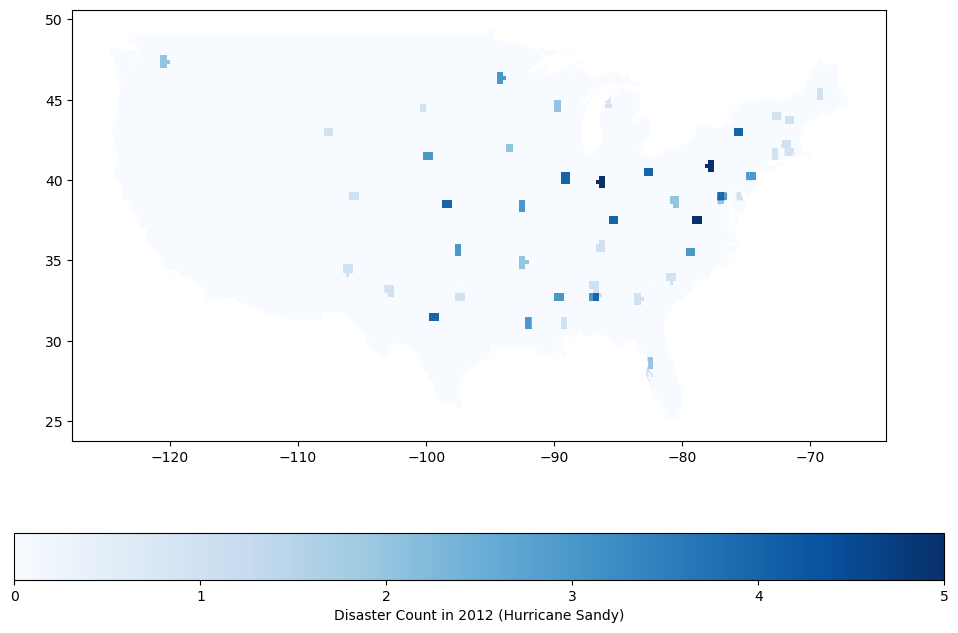

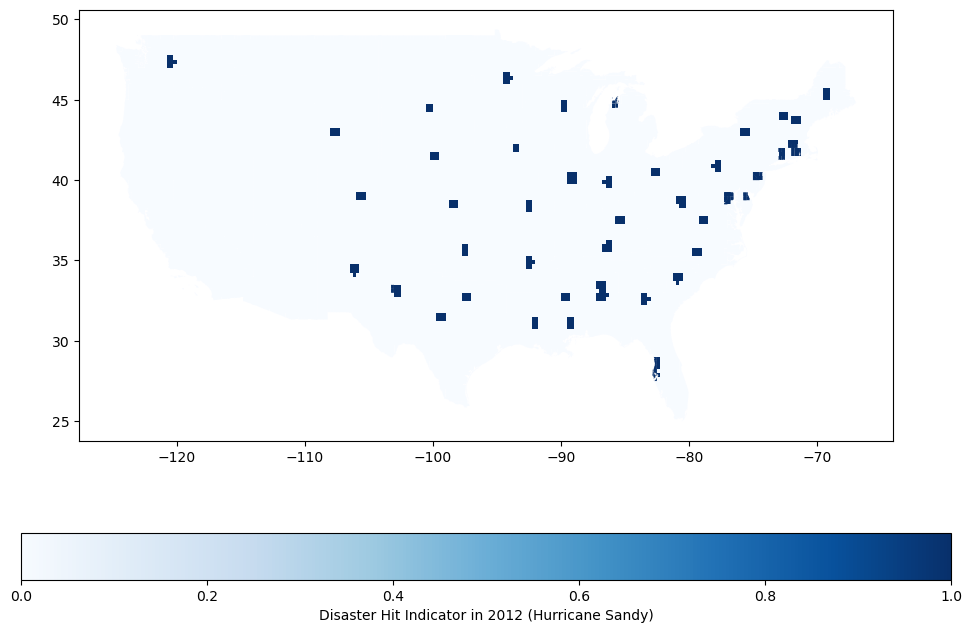

In [37]:
import matplotlib.pyplot as plt
# 6.2 Plot on a map, disaster counts by grid cell in the year 2012 (Hurricane Sandy)
sandy_year_data = merged_grid_inventors_panel[merged_grid_inventors_panel['year'] == 2012].merge(
    grid[['grid_id', 'geometry']], on='grid_id', how='left'
)
sandy_year_data = gpd.GeoDataFrame(
    sandy_year_data,
    geometry=sandy_year_data['geometry'],
    crs="EPSG:4326"
)
# Use blue color map for better visibility
sandy_year_data.plot(column='count', legend=True, figsize=(12, 8), edgecolor='none', cmap='Blues', legend_kwds={'label': "Disaster Count in 2012 (Hurricane Sandy)", 'orientation': 'horizontal'})
sandy_year_data.plot(column='hit', legend=True, figsize=(12, 8), edgecolor='none', cmap='Blues', legend_kwds={'label': "Disaster Hit Indicator in 2012 (Hurricane Sandy)", 'orientation': 'horizontal'})



<Axes: >

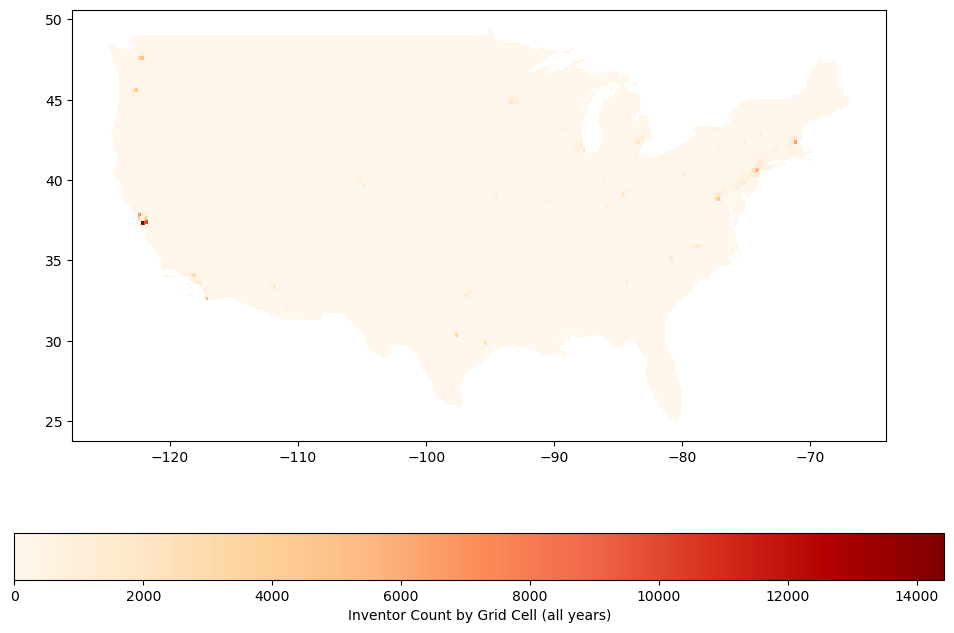

In [38]:
# 6.3 Plot on a map, inventor counts by grid cell for all years
inventor_counts = merged_grid_inventors_panel.groupby(['grid_id', 'year'])['n_inventors'].sum().reset_index()
inventor_counts = inventor_counts.merge(grid[['grid_id', 'geometry']], on='grid_id', how='left')
inventor_counts = gpd.GeoDataFrame(
    inventor_counts,
    geometry=inventor_counts['geometry'],
    crs="EPSG:4326"
)
inventor_counts.plot(column='n_inventors', legend=True, figsize=(12, 8), edgecolor='none', cmap='OrRd', legend_kwds={'label': "Inventor Count by Grid Cell (all years)", 'orientation': 'horizontal'})

In [39]:
# 6.4 Summary statistics
merged_grid_inventors_panel[['count', 'n_inventors']].describe(), merged_grid_inventors_panel['hit'].value_counts(normalize=True)

(               count    n_inventors
 count  370512.000000  370512.000000
 mean        0.051618      12.552633
 std         0.364957     125.080831
 min         0.000000       0.000000
 25%         0.000000       0.000000
 50%         0.000000       0.000000
 75%         0.000000       1.000000
 max        10.000000   14432.000000,
 hit
 0.0    0.969577
 1.0    0.030423
 Name: proportion, dtype: float64)

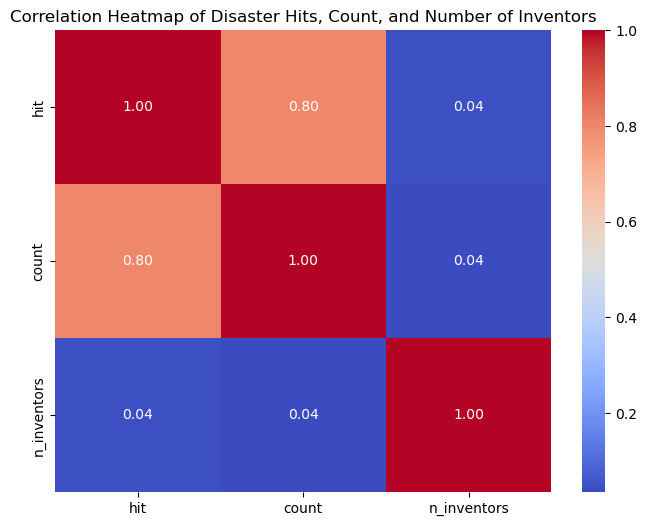

In [40]:
# 6.3 Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
corr = merged_grid_inventors_panel[['hit', 'count', 'n_inventors']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Disaster Hits, Count, and Number of Inventors')
plt.show()